In [1]:
%matplotlib inline
import itertools
import math
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import beta

import torch
from torch import nn, tensor

In [2]:
class Dataset(object):
    """Wrap input and output data, and provide some convenience methods."""
    def __init__(self, x, y):
        assert len(x) == len(y)
        self.x = x
        self.y = y
        self.num_rows, self.num_cols = x.shape

    def __repr__(self):
        return f'x:\n{self.x}\ny:\n{self.y}'

    def shuffled(self):
        """Permute the first axis of x and y."""
        shuffle = np.random.permutation(len(self.x))
        return Dataset(self.x[shuffle], self.y[shuffle])

    def tensor(self):
        """Convert from numpy.ndarray to torch.tensor."""
        return Dataset(torch.from_numpy(self.x), torch.from_numpy(self.y))

    def split(self, ratio):
        """Split data along first axis."""
        n = len(self.x)
        assert n > 1

        s = max(1, math.floor(ratio*n))

        return (Dataset(self.x[:s], self.y[:s]),
                Dataset(self.x[s:], self.y[s:])
               )


def binary_vectors(n):
    """Create a dataset to test learning equality.
    
    Positive instances look like [v, v]
    Negative instances look like [v, u]
    
    where u, v are binary vectors of length n and u != v.
    """

    # Generate a list of all binary tuples with n elements
    vecs = list(itertools.product((0, 1), repeat=n))

    x = [v + v for v in vecs]  # Equal pairs (positive instances)
    y = [1 for v in vecs]  # Labels for positive instances

    # Generate a negative instance for each positive instance
    for v in vecs:

        # Randomly choose a vector until we pick one that is
        # not equal to v. This will be a negative instance
        while True:

            u = random.choice(vecs)

            if u != v:

                x.append(u + v)
                y.append(0)
                break

    x = np.array(x, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return Dataset(x, y)


def compute_accuracy(net, data):
    with torch.no_grad():
        p = net(data.x).view(-1)

    y = data.y.numpy()
    y_hat = (p.data.numpy() > 0).astype(int)
    return (y == y_hat).sum() / data.num_rows

In [3]:
train_accuracies = []
test_accuracies = []
num_repetitions = 100
max_epochs = 100_000
minibatch_size = 4
input_size = 5
hidden_size = 5


for repetition in range(num_repetitions):

    data = binary_vectors(input_size).shuffled().tensor()
    assert data.num_rows == 2**(input_size + 1)
    
    train_data, test_data = data.split(0.75)

    net = nn.Sequential(nn.Linear(train_data.num_cols, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, 1)
                       )
    
    opt = torch.optim.SGD(net.parameters(), lr=0.002)
    
    for epoch in range(max_epochs):

        sum_loss = 0
        train_data = train_data.shuffled()

        for i in range(0, train_data.num_rows, minibatch_size):

            j = i + minibatch_size
            x = train_data.x[i:j]
            y = train_data.y[i:j]

            net.zero_grad()
            p = net(x).view(-1)
            loss = nn.functional.binary_cross_entropy_with_logits(p, y)

            loss.backward()
            opt.step()

            sum_loss += loss.item()

        if epoch % 1000 == 0:
            accuracy = compute_accuracy(net, train_data)
            if accuracy > 0.99:
                print(f'[{repetition}] terminated after {epoch} epochs (train accuracy: {accuracy})')
                break
    else:
        accuracy = compute_accuracy(net, train_data)
        print(f'[{repetition}] terminated without success (train accuracy: {accuracy})')
    
    train_accuracies.append(compute_accuracy(net, train_data))
    test_accuracies.append(compute_accuracy(net, test_data))

[0] terminated after 5000 epochs (train accuracy: 1.0)
[1] terminated after 7000 epochs (train accuracy: 1.0)
[2] terminated after 3000 epochs (train accuracy: 1.0)
[3] terminated after 7000 epochs (train accuracy: 1.0)
[4] terminated after 8000 epochs (train accuracy: 1.0)
[5] terminated after 7000 epochs (train accuracy: 1.0)
[6] terminated after 6000 epochs (train accuracy: 1.0)
[7] terminated after 3000 epochs (train accuracy: 1.0)
[8] terminated after 8000 epochs (train accuracy: 1.0)
[9] terminated after 9000 epochs (train accuracy: 1.0)
[10] terminated after 43000 epochs (train accuracy: 1.0)
[11] terminated after 6000 epochs (train accuracy: 1.0)
[12] terminated after 4000 epochs (train accuracy: 1.0)
[13] terminated after 10000 epochs (train accuracy: 1.0)
[14] terminated after 5000 epochs (train accuracy: 1.0)
[15] terminated after 4000 epochs (train accuracy: 1.0)
[16] terminated after 9000 epochs (train accuracy: 1.0)
[17] terminated after 5000 epochs (train accuracy: 1.0)


median: 0.8125
mean: 0.756875
std: 0.15956361388173684


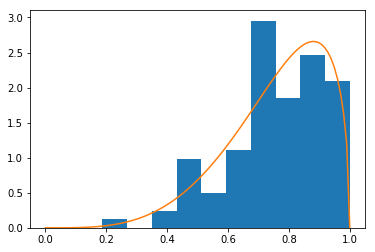

In [4]:
print('median:', np.median(test_accuracies))
print('mean:', np.mean(test_accuracies))
print('std:', np.std(test_accuracies))


# Beta distribution MLE

m = np.mean(test_accuracies)
v = np.var(test_accuracies, ddof=1)
c = m * (1 - m) / v - 1
a = m * c
b = (1 - m) * c

x = np.linspace(0, 1, 100)
plt.hist(test_accuracies, density=True)
plt.plot(x, beta.pdf(x, a, b))